# Results analysis & visualisation

This notebook evaluates and concludes conducted research regarding text detoxcification.

In [1]:
!pip install -q datasets transformers[sentencepiece] sacrebleu
!pip install -q evaluate
!pip install -q langchain
!pip install -q sentence-transformers

In [2]:
import warnings

import gc
from datasets import load_dataset, load_metric
import transformers
import datasets
import random
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import tqdm
from tqdm.auto import trange
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification, \
                         DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, \
                         RobertaTokenizer, RobertaForSequenceClassification

import evaluate
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading the models & results

Since it's not very convinient to load all the models & run them once again, the predictions from the models have been collected in `csv` files. These files contain:
1. `Query` -- `reference` column from the test part of [utilized dataset](https://huggingface.co/datasets/domrachev03/toxic_comments_subset)
2. `Labels` -- `translation` column from the dataset. Represents the original paraphrased predictions
3. `Predictions` -- the output, generated by corresponding model.

> Note. All the model, except for the Llama2 7b, was computed on the whole test dataset of 17.7k entries. The Llama2 was computed on 5k entries due to computational limitations

Let's load them:

In [3]:
# gpt_results = pd.read_csv('../../data/models_test_data/llama_test.csv', index_col=0)
# t5_results = pd.read_csv('../../data/models_test_data/t5_test.csv', index_col=0)
# t5_rl_results = pd.read_csv('../../data/models_test_data/llama_test.csv', index_col=0)
# llama2_results = pd.read_csv('../../data/models_test_data/llama_test.csv', index_col=0)
gpt_results = pd.read_csv('/kaggle/input/results-of-assignment/gpt_test.csv', index_col=0)
t5_results = pd.read_csv('/kaggle/input/results-of-assignment/t5_test.csv', index_col=0)
t5_rl_results = pd.read_csv('/kaggle/input/results-of-assignment/t5_rl_test.csv', index_col=0)
llama2_results = pd.read_csv('/kaggle/input/results-of-assignment/llama_test.csv', index_col=0)

results = {
    'gpt2': gpt_results, 
    't5': t5_results, 
    't5_rl': t5_rl_results, 
    'llama2': llama2_results
}

In [4]:
results['llama2'].head()

,Query,Predictions,Labels
0,"If they say they don't want your help, you can...","if they say they don't want your help, you can...","if they say they don't need help, you can bet ..."
1,"When you go home, they'il call you ""Mr. No-Leg...","When you get home, they'll call you ""Mr. No-Le...","when you get home, they'll call you Mr."
2,Mrs. Sanders ain't goingfor that late shit no ...,Mrs. Sanders won't be doing that late stuff an...,Mrs. Sanders is not curious about being late.
3,I want every bloody one of them to hear.,I want everyone to hear it.,I want everyone to hear it.
4,That shit hurt.,that hurt.,and that really hurts.


# Results evaluation

## Metric evaluation

The baseline metric for the comparison was taken from the research "[Reformulating Unsupervised Style Transfer as Paraphrase Generation](https://doi.org/10.18653/v1/2020.emnlp-main.55)", which was interpreted as follows:
1. Accuracy -- the estimation of non-toxicity of the text, performed by RoBerta, finetuned on toxicity classification ([link](https://huggingface.co/SkolkovoInstitute/roberta_toxicity_classifier)). The higher score -- the less toxic text is.
2. Content preservation -- contrary to the paper statement, the [sacreBLEU](https://huggingface.co/spaces/evaluate-metric/sacrebleu) score is used, since there is no convinient implementation of this model available. The values are scaled to range $[0; 1]$ 
3. Fluency -- the fluency was evaluated via RoBerta, fituned on evaluation of language fluency, provided by the authors of the paper ([link](https://huggingface.co/cointegrated/roberta-large-cola-krishna2020)).

Their summarization is joint metric $J$, which represeants arithmetic mean of three values.

Let's validate all the predictions via this metric:

In [5]:
def cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def get_toxicity(preds, soft=False, batch_size=1, device='cuda'):
    results = []

    model_name = 'SkolkovoInstitute/roberta_toxicity_classifier'

    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name)
    device = device
    model.to(device)

    model.eval()
    for i in tqdm.tqdm(range(0, len(preds), batch_size)):
        batch = tokenizer(preds[i:i + batch_size], return_tensors='pt', max_length=-1, padding=True).to(device)

        with torch.no_grad():
            logits = model(**batch).logits
            out = torch.softmax(logits, -1)[:, 1].cpu().numpy()
            results.append(out)
    return 1 - np.concatenate(results)


def get_sacrebleu(inputs, preds):
    metric = evaluate.load("sacrebleu")

    result = metric.compute(predictions=preds, references=inputs)
    return result['score']


def get_fluency(preds, soft=False, batch_size=1, device='cuda'):
    path = 'cointegrated/roberta-large-cola-krishna2020'

    model = RobertaForSequenceClassification.from_pretrained(path)
    tokenizer = AutoTokenizer.from_pretrained(path)
    device = device
    model.to(device)

    results = []
    for i in trange(0, len(preds), batch_size):
        batch = [t for t in preds[i: i + batch_size]]
        inputs = tokenizer(batch, max_length=-1, padding=True, return_tensors='pt').to(device)
        with torch.no_grad():
            out = torch.softmax(model(**inputs).logits, -1)[:, 0].cpu().numpy()
            results.append(out)
    return np.concatenate(results)


def compute_metrics(eval_preds, tokenizer=None, print_results=False, batch_size=1, device='cuda', model_name=""):
    preds, labels = eval_preds
    
    if tokenizer is not None:
        detokenized_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        filtered_labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        detokenized_labels = tokenizer.batch_decode(filtered_labels, skip_special_tokens=True)
    else:
        detokenized_preds = preds
        detokenized_labels = labels

    results = {}
    results['toxic'] = get_toxicity(detokenized_preds, batch_size=batch_size, device=device)
    results['avg_toxic'] = sum(results['toxic']) / len(results['toxic'])
    cleanup()

    results['bleu'] = get_sacrebleu(detokenized_labels, detokenized_preds) / 100
    cleanup()

    results['fluency'] = get_fluency(detokenized_preds, batch_size=batch_size, device=device)
    results['avg_fluency'] = sum(results['fluency']) / len(results['fluency'])
    cleanup()

    # count metrics
    results['joint'] = sum(results['toxic'] * results['bleu'] * results['fluency']) / len(preds)
    if print_results:
        if model_name != "":
            print("--------------")
            print(model_name)
        print("--------------")
        print("Metric   | Value")
        print("--------------")
        print(f"toxic    | {results['avg_toxic']:.2f}")
        print(f"bleu (n) | {results['bleu']:.2f}")
        print(f"fluency  | {results['avg_fluency']:.2f}")
        print("===============")
        print(f"Total    | {results['joint']:.2f}")
        print("--------------")
    return results

preds = ["Go away!", "Fuck you bitch sosi!", "fuck you!"]
labels = [["Fuck!"], ["Fuck!"], ["Fuck!"]]

compute_metrics((preds, labels), print_results=True)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

--------------
Metric   | Value
--------------
toxic    | 0.33
bleu (n) | 0.09
fluency  | 0.89
Total    | 0.03
--------------


{'toxic': array([9.8291349e-01, 3.8629770e-04, 3.9476156e-04], dtype=float32),
 'avg_toxic': 0.32789818445841473,
 'bleu': 0.0918014067473398,
 'fluency': array([0.9906026 , 0.6954773 , 0.98933053], dtype=float32),
 'avg_fluency': 0.8918034831682841,
 'joint': 0.02981513586140257}

In [6]:
metric_values = {}
for model_name, preds in results.items():
    preds = preds.dropna()
    print(f'Model {model_name}')
    metric_values[model_name] = compute_metrics(
        (preds['Predictions'].tolist(), preds['Labels'].tolist()), 
        print_results=True, batch_size=128,
        model_name=model_name
    )


Model gpt2


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 136/136 [00:03<00:00, 35.18it/s]


  0%|          | 0/136 [00:00<?, ?it/s]

--------------
gpt2
--------------
Metric   | Value
--------------
toxic    | 1.00
bleu (n) | 0.00
fluency  | 0.85
Total    | 0.00
--------------
Model t5


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 136/136 [00:14<00:00,  9.61it/s]


  0%|          | 0/136 [00:00<?, ?it/s]

--------------
t5
--------------
Metric   | Value
--------------
toxic    | 0.74
bleu (n) | 0.24
fluency  | 0.83
Total    | 0.15
--------------
Model t5_rl


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 136/136 [00:14<00:00,  9.57it/s]


  0%|          | 0/136 [00:00<?, ?it/s]

--------------
t5_rl
--------------
Metric   | Value
--------------
toxic    | 0.93
bleu (n) | 0.03
fluency  | 0.48
Total    | 0.01
--------------
Model llama2


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 40/40 [00:11<00:00,  3.43it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

--------------
llama2
--------------
Metric   | Value
--------------
toxic    | 0.69
bleu (n) | 0.21
fluency  | 0.91
Total    | 0.13
--------------


In [7]:
from matplotlib import pyplot as plt

In [49]:
def visualize_metrics(metrics, metric_names, use_benchmark=True, save=False, fname='image/metrics.png'):
    fig, ax = plt.subplots(2, 2, figsize=(2*8, 2*3))
    ax = ax.ravel()
    if use_benchmark:
        metrics['CondBert'] = {
            'avg_toxic': 0.93,
            'bleu': 0.125,
            'avg_fluency': 0.62,
            'joint': 0.125
        }
        metrics['ParaGeDi'] = {
            'avg_toxic': 0.93,
            'bleu': 0.038,
            'avg_fluency': 0.88,
            'joint': 0.038
        }
        
    i = 0
    model_names = list(metrics.keys())
    n_models = len(model_names)
    
    for i, metric_name in enumerate(metric_names):
        cur_metric_values = []
        for model_name, model_metrics in metrics.items():
            cur_metric_values.append(model_metrics[metric_name])
            
        ax[i].set_ylabel("Values")
        ax[i].set_title(metric_name.replace('_', ' ').capitalize())
        ticks = range(n_models)
        ax[i].set_xticks(ticks, labels = model_names, rotation='horizontal')
        color = ['b' for _ in range(n_models)]
        if use_benchmark:
            color[-2:]=['r', 'r']
            print(color)
        p = ax[i].bar(ticks, cur_metric_values, color=color)
        
        
    plt.tight_layout()
    if save:
        plt.savefig(fname)
    else:
        plt.show()
    plt.clf()

['b', 'b', 'b', 'b', 'r', 'r']
['b', 'b', 'b', 'b', 'r', 'r']
['b', 'b', 'b', 'b', 'r', 'r']
['b', 'b', 'b', 'b', 'r', 'r']


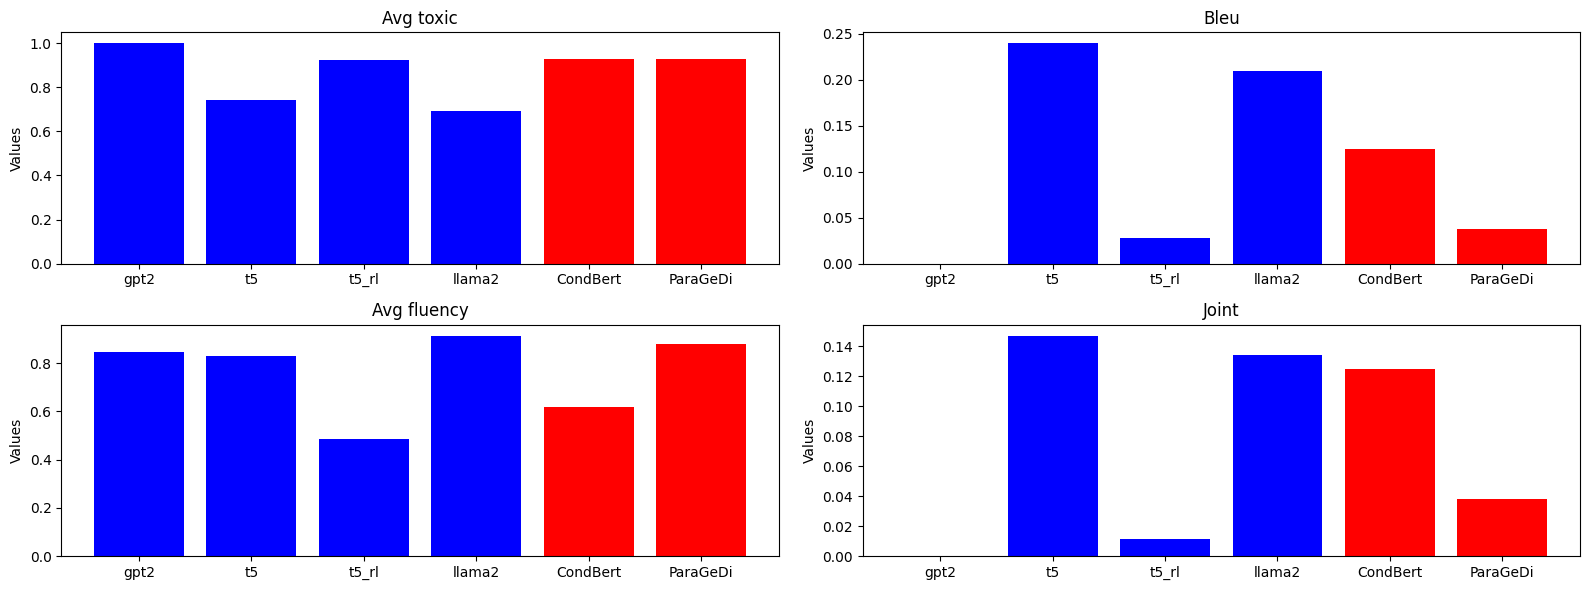

<Figure size 640x480 with 0 Axes>

In [53]:
visualize_metrics(
    metric_values, 
    ['avg_toxic', 'bleu', 'avg_fluency', 'joint'], 
    save=False, 
    fname = 'image/metrics.png'
)

As one could see, the `t5` model shows the best joint score among all the models. But would it correspond to the human evaluation?

## Human evaluation

Let's print the paraphrazed version of the same sentence from different datasets:

In [75]:
def print_phrases(reference, results_dict, ref_column_name = 'Query', resp_column_name = 'Predictions'):
    print('-----------------------')
    print(f'Original: "{reference}"')
    print('Paraphrases:')
    for model_name, results in results_dict.items():
        resp = results[results[ref_column_name]==reference][resp_column_name].item()
        print(4*' ', f'{model_name}: "{resp}"')

In [76]:
queries_range = len(results['llama2']['Query'])
for i in range(10):
    random_phrase = results['llama2']['Query'][np.random.randint(queries_range)]
    print_phrases(random_phrase, results)

-----------------------
Original: "if he sees the dog, we're screwed."
Paraphrases:
     gpt2: " Circ"
     t5: "If he sees the dog, we're screwed."
     t5_rl: "the sentence non-toxic."
     llama2: "if he sees the dog, we're in trouble."
-----------------------
Original: "hey, Barrie, what the fuck are you doing?"
Paraphrases:
     gpt2: " Tac"
     t5: "Barrie, what are you doing?"
     t5_rl: "Make the following sentence non-toxic: 'hey, Barrie, what are you doing"
     llama2: "hey, Barrie, what are you doing?"
-----------------------
Original: "Why the fuck did you hug my head?"
Paraphrases:
     gpt2: "sectional"
     t5: "why did you hug my head?"
     t5_rl: "Make the following sentence non-toxic: 'Why the fist did you have your"
     llama2: "Why did you hug my head?"
-----------------------
Original: "He ain't got a goddamn conscience."
Paraphrases:
     gpt2: "rade"
     t5: "he doesn't have a conscience."
     t5_rl: "the sentence non-toxic."
     llama2: " he doesn't have

Unfortunately, the gpt2 is not able to output anything longer than 1 word. Meanwhile, the `T5` finetuned on one epoch sometimes output a meaningful result, however most of the time it shows its overfitting on the prompt.

Comparing the `T5` and `Llama2`, I personally think that `Llama2` wins. It performs more fluent and meaningful paraphrasing, which might differ on word level from the original sentence, but stays closer in meaning. 

# Conclusion

Let's quickly overview the performance of each model and then draw a conclusion

## GPT2

The GPT2 model comletely failed to solve given task. Despite big chunk of dataset and enough learning epoches, it did not respond adequately.

Possible adjustments:
1. During investigating a Transformers Reinforcement Learning, I discovered an interesting technique of randomly trimming, and ask a ChatGPT to complete it. This approach might help GPT2 to understand the dependency.
2. Take more powerful version of the model, f.e. gpt2-medium (there are actually some detoxifying solutions with this models, [ref](https://huggingface.co/s-nlp/gpt2-base-gedi-detoxification))
3. Change loss function

## T5

This model showed wonderful results with respect to its size and the limited amount of data. It is very close to outperforming Llama2, which is 7000+ times bigger. 

The only possible improvement seems to be increasing the size of the model and extending the dataset.

## T5-RL

The promising idea of reinforcement learning turned out to work poorly. The biggest problems are training time (which is 10x from usual finetuning routine) and nontrivial cost function, which made the process of tuning the result extremely hard.

Possible adjustments:
1. Play around with cost function and find a better option

## Llama2

The Llama2, as expected, showed a deep understanding of the context and completed the task with flying colours (despite being underestimated by the metrics). However, considering its size, it is out of contest.

Regarding adjustments, I believe that the capabilities of this model are still underestimated, and it could be improved by either increasing the dataset and learning time, or by applying few-shots technique.

## Conclusion

The best model I'd choose is `t5-small` -- the smallest model among others, and yet the most successful.